### Import Libraries

In [1]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
# #SELECT GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Create  game environment and examine observation

In [2]:
env = gym.make("CartPole-v0") #choose the game

obs = env.reset()
# plt.figure()
# plt.imshow(obs)
# plt.colorbar()
# plt.grid(False)
np.shape(obs)

(4,)

### Look at Data

In [3]:
state_size = env.observation_space.shape[0]

### Model

episode is done
reward_sum: 12.0
episode is done
reward_sum: 18.0
episode is done
reward_sum: 40.0
episode is done
reward_sum: 19.0
episode is done
reward_sum: 181.0
episode is done
reward_sum: 26.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 194.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 171.0
episode is done
reward_sum: 126.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 144.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 163.0
episode is done
reward_sum: 191.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 121.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
reward_sum: 200.0
episode is done
rew

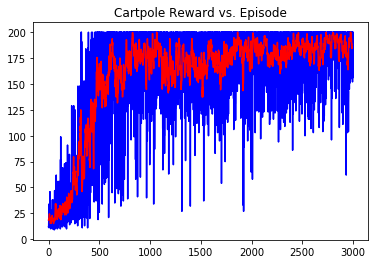

In [4]:

# hyperparameters
H = 10 # number of hidden layer neurons
learning_rate = 1e-3
gamma = 0.95 # discount factor for reward

# model initialization
D = 4 # input dimensionality
C = 2 # class number

def policy_gradient():
    with tf.variable_scope("policy"):
        state = tf.placeholder(tf.float32, [None, D])
        actions = tf.placeholder(tf.int32, [None, 1])
        rewards = tf.placeholder(tf.float32, [None, 1])

        #Single layer relu, + softmax output
        hidden_lyr = tf.layers.dense(activation=tf.nn.relu, inputs= state, units=H, kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_lyr = tf.layers.dense(activation=tf.nn.softmax, inputs = hidden_lyr, units = 2)        
        probabilities = output_lyr

        prob_given_state = tf.reduce_sum(-tf.log(probabilities) * tf.one_hot(actions, C), axis=0)
        #Negative probability 
        #Maximize prob of actions that have high rewards, minimize for low (negative)
        loss = tf.reduce_mean(prob_given_state * rewards)

        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        return probabilities, state, actions, rewards, optimizer

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    #Standardize rewards
    discounted_r -= np.mean(discounted_r)
    discounted_r /= np.std(discounted_r)
    return discounted_r

def choose_action(prob):
    action = np.random.choice(range(len(prob)), p=prob)  # select action w.r.t the actions prob
    return action

tf.reset_default_graph()
policy_grad = policy_gradient()

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

reward_sum = 0
reward_trend = []
for episode_number in range(3000):
    #Batch size is 1
    observation = env.reset()
    feed_states, feed_actions, feed_reward = [], [], []
    reward_sum = 0
    pl_calculated, pl_state, pl_actions, pl_advantages, pl_optimizer = policy_grad

    for _ in range(300):
        #The game anyway ends at 200
        state = observation #shape (D,)
        
        aprob = sess.run(pl_calculated, feed_dict={pl_state: np.reshape(state, (1, D))}) # aprob's shape: 1 * C
        action = choose_action(aprob[0]) # select an action based on policy gradient
        feed_states.append(state)

        feed_actions.append(action)

        # step the environment and get new measurements
        observation, reward, done, info = env.step(action)
        reward_sum += reward
        feed_reward.append(reward)

        if done: # an episode finished
            if episode_number % 100 == 0:
                print("episode is done")
                print("reward_sum: {}".format(reward_sum))

            reward_trend.append(reward_sum)
            feed_advantages = discount_rewards(feed_reward) # compute discounted and normalized rewards
            #Train policy gradient model
            sess.run(pl_optimizer, feed_dict={pl_state: np.vstack(feed_states), pl_advantages: np.vstack(feed_advantages), pl_actions: np.vstack(feed_actions)})
            break
sess.close()
plt.clf()
plt.plot(reward_trend, color = 'blue')
plt.plot(np.convolve(reward_trend, np.ones((10,))/10, mode='valid'),color = 'red')
plt.title('Cartpole Reward vs. Episode')
plt.savefig('cartpole_reward_trend.png')

plt.show()


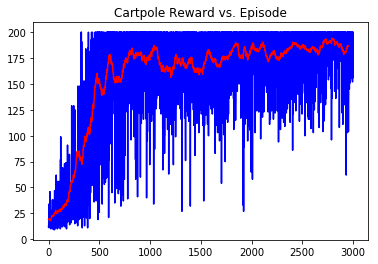

In [6]:
#Note - without the baseline that was implemented for pong, we can see very varied results on re--runs of this.
plt.clf()
plt.plot(reward_trend, color = 'blue')
plt.plot(np.convolve(reward_trend, np.ones((50,))/50, mode='valid'),color = 'red')
plt.title('Cartpole Reward vs. Episode')
plt.savefig('cartpole_reward_trend.png')
#plt.plot(reward_trend)
plt.show()